Problem Defintion:
- I believe that we can improve the previous method for ranking donors included in a given telemarketing campaign.
- The current system uses a linear model based on ordered categories, for example:
    - set AmerScore = AmerScore + 
        case
            when LifetimeRevenueSum >= 5000 then 1000
            when LifetimeRevenueSum BETWEEN 1000 AND 4999.99 THEN 500
            when LifetimeRevenueSum BETWEEN 500 AND 999.99 THEN 300
            when LifetimeRevenueSum BETWEEN 250 AND 499.99 then 250
            when LifetimeRevenueSum BETWEEN 100 AND 249.99 then 200
            when LifetimeRevenueSum BETWEEN 50 AND 99.99 then 150
            when LifetimeRevenueSum between 25 and 49.99 then 100
            when LifetimeRevenueSum < 25 then 10
            else 0
        end 
    - set AmerScore = AmerScore + 
        case
            when LifetimeGiftCount >= 10 then 300
            when LifetimeGiftCount between 5 and 9 then 225
            when LifetimeGiftCount between 3 and 4 then 150
            when LifetimeGiftCount = 2 then 100
            when LifetimeGiftCount = 1 then 1
        else 0
       end
       
- Using the same variables as those used in this previous model, I aim to explore the relationship between the variables and the target variable (give/do not give; if give, how much), the relationships between these variables, and finally perform a regression analysis using historical data from past telemarketing campaigns.

- Let us begin by imporing the necessary modules and our dataset
- The data was extracted from SSMS pulling various a number of different tables.
- The data pertains to the fourth telemarketing campaign of 2017 Fiscal Year

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from sklearn.linear_model import LogisticRegression

pd.options.mode.chained_assignment = None
%matplotlib inline

C:\Users\awright\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_csv("C:/Users/awright/Desktop/August 2017/Other/Resources/Machine Learning/Project1/17LTEL/17LTELTEL4_ContModel08242017.csv")

In [5]:
df['GivingFlag'] = 0
df['GivingFlag'].loc[df.TotalAmount > 0.0] = 1

In [6]:
print(df.shape)
df.head()

(117392, 10)


,donorid,Recency,TwoYearCount,LifeCount,LifeSum,TotalAmount,YrsSinceMember,AmerDecile,AmerPriority,GivingFlag
0,3543063,935,6,2,50.0,0.0,3,7,112959,0
1,5914874,364,1,1,20.0,0.0,1,9,133789,0
2,37742830,487,1,19,505.0,0.0,8,1,9155,0
3,6070700,308,1,1,15.0,0.0,1,8,125501,0
4,5522552,493,1,1,25.0,0.0,1,8,118713,0


In [7]:
df.groupby('GivingFlag').mean()

,donorid,Recency,TwoYearCount,LifeCount,LifeSum,TotalAmount,YrsSinceMember,AmerDecile,AmerPriority
GivingFlag,,,,,,,,,
0,1.601221e+07,575.969866,2.722153,9.912890,283.399431,0.000000,7.053135,5.542260,84067.361107
1,1.695893e+07,485.295622,2.525791,11.001734,320.978925,29.171175,7.520156,5.302991,79924.700043


A quick review of the means demonstrates a difference in the average values for our variables comparing those who give to those who do not.  Quite pronounced are Recency, LifeCount, and LifeSum.

In [17]:
df.describe()

,donorid,Recency,TwoYearCount,LifeCount,LifeSum,TotalAmount,YrsSinceMember,AmerDecile,AmerPriority,GivingFlag
count,1.173920e+05,117392.000000,117392.000000,117392.000000,117392.000000,117392.000000,117392.000000,117392.000000,117392.000000,117392.000000
mean,1.603082e+07,574.187926,2.718294,9.934289,284.137947,0.573275,7.062313,5.537558,83985.949094,0.019652
std,1.503145e+07,227.890601,2.154172,19.262331,1768.490313,8.373618,7.330589,2.951887,49357.832153,0.138802
min,6.700000e+01,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,4.216791e+06,377.000000,1.000000,2.000000,40.000000,0.000000,2.000000,3.000000,40520.250000,0.000000
50%,5.893738e+06,531.000000,2.000000,4.000000,85.000000,0.000000,4.000000,6.000000,83541.500000,0.000000
75%,3.143252e+07,738.000000,6.000000,10.000000,215.000000,0.000000,10.000000,8.000000,128359.250000,0.000000
max,4.338176e+07,1112.000000,23.000000,462.000000,295800.000000,1000.000000,51.000000,10.000000,167011.000000,1.000000


We can see here that we have some unwieldy standard deviations to work with..  Note the Recency, LifeCount, and LifeSum std...

Let's isolate our explanatory variables (LifeCount, LifeSum, Recency, and TwoYearCount), and look at some plots to visualize our dataset.

In [8]:
df_train_cols = df.columns[1:5]
df_train = df[df_train_cols]

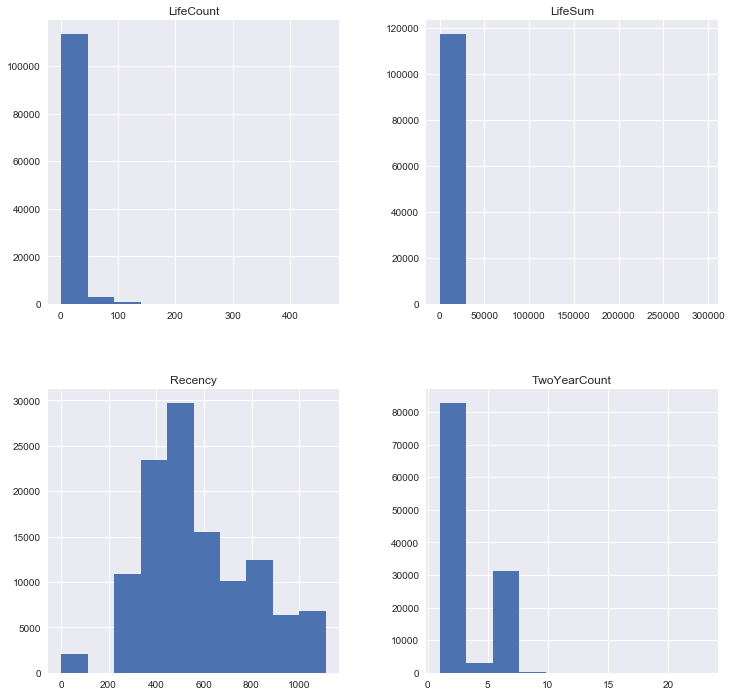

In [9]:
df_train.hist(figsize=(12,12))
plt.show()

This is not exactly a pretty picture.  Clearly there are some extreme outliers in LifeCount, LifeSum, and TwoYearCount that are preventing us from seeing finer details. 

What if we tug the outliers in to a more reasonable upper limit?

In [11]:
LifeSum_Ulim = np.percentile(df.LifeSum.values,95)
LifeCount_Ulim = np.percentile(df.LifeCount.values,95)
TwoYearCount_Ulim = np.percentile(df.TwoYearCount.values,99)

df['LifeSum'].loc[df['LifeSum'] > LifeSum_Ulim] = LifeSum_Ulim
df['LifeCount'].loc[df['LifeCount'] > LifeCount_Ulim] = LifeCount_Ulim
df['TwoYearCount'].loc[df['TwoYearCount'] > TwoYearCount_Ulim] = TwoYearCount_Ulim

In [12]:
df_train_cols = df.columns[1:5]
df_train = df[df_train_cols]

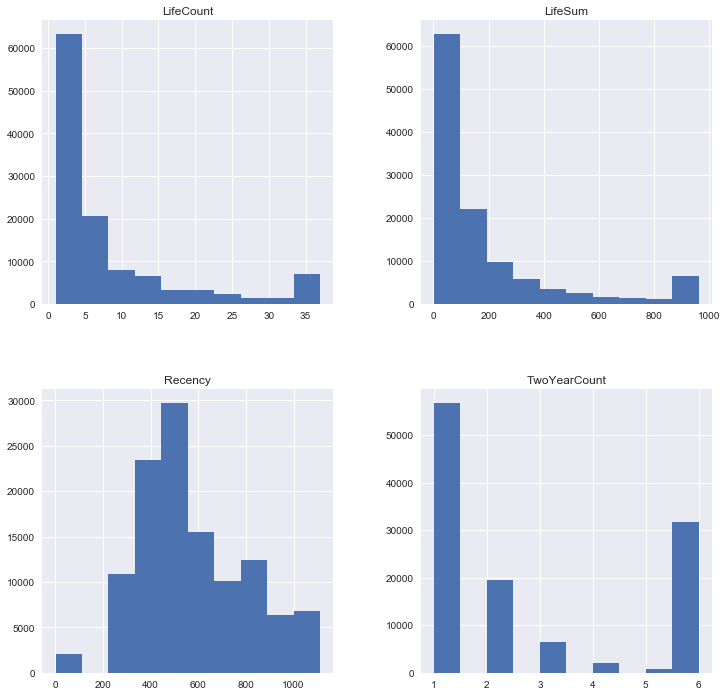

In [13]:
df_train.hist(figsize=(12,12))
plt.show()

That's a bit better...  It looks like Life Count and Life Sum might be strongly correlated.  But before we get into correlations between explanatory variables, let's looks at how each out of explanatory variables correlates with the target variable (binary give/not give)

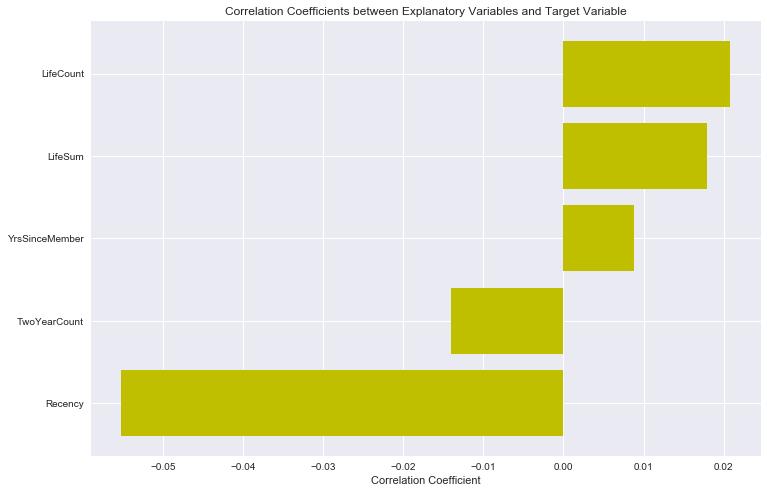

In [14]:
x_cols = [col for col in df.columns if col not in ['GivingFlag','TotalAmount','donorid','AmerPriority','AmerDecile']]

labels = []
values = []

for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.GivingFlag.values)[0,1])

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values}, index = labels)
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation = 'horizontal')
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficients between Explanatory Variables and Target Variable")
#autolabel(rects)
plt.show()

It appears that, in out dataset, Recency has the strongest correlation with donating.  Considering that the max of Recency is 1112, this seems to be a legitimate insight.  LifeCount and LifeSum are agains showing signs of similarity in behavior.  YrsSinceMember has the lowest, while TwoYearCount comes in with a negative correlation, which goes against my intuition about donor behavior. 

Now let's take a look at the relationships between our Explanatory variables.

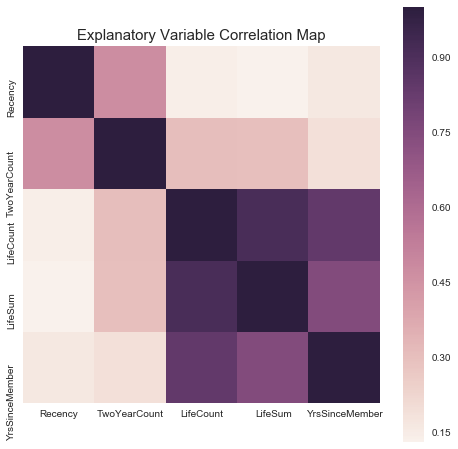

In [15]:
corrmat = df[x_cols].corr(method='spearman')
f, ax = plt.subplots(figsize=(8,8))

sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Explanatory Variable Correlation Map", fontsize=15)
plt.show()

As was expected, LifeCount and LifeSum are strongly correlated.  YrsSinceMember also demonstrates a strong correlation with LifeSum and LifeCount as well -- this is not surprising, but it would also not exactly be expeceted IMO.

Let's visualize the strong correlation between LifeCount and LifeSum.

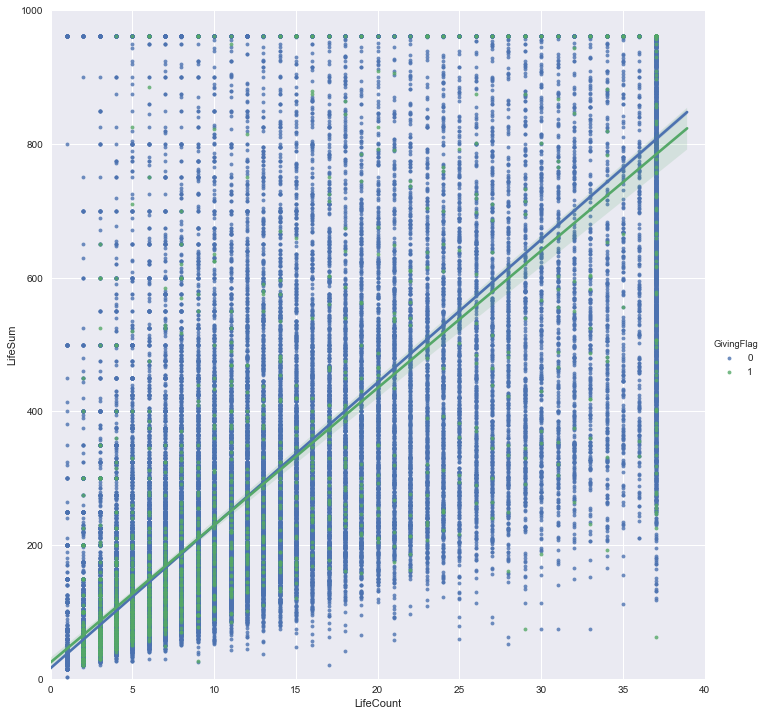

In [37]:

lm =sns.lmplot('LifeCount','LifeSum',data=df, hue='GivingFlag', fit_reg=True, scatter_kws={"s": 15}, size=10)
lm.axes[0,0].set_ylim(0,1000)
lm.axes[0,0].set_xlim(0,40)
plt.show()

Yikes!  How are we supposed to sort this mess out?  The fact that LifeCount and LifeSum are correlated provides little comfort.

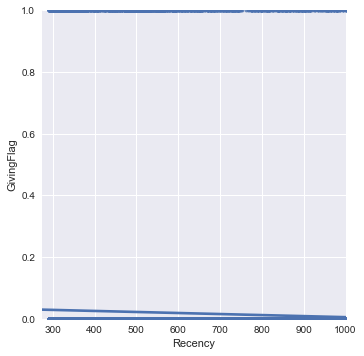

In [46]:
plt.figure(figsize=(8,8))
lm =sns.lmplot('Recency', 'GivingFlag',data=df, fit_reg=True, scatter_kws={"s": 15}, size=5)
lm.axes[0,0].set_ylim(0,1)
lm.axes[0,0].set_xlim(275,1000)
plt.show()

There is a sliver of hope!

In [49]:
from imblearn.over_sampling import RandomOverSampler


ModuleNotFoundError: No module named 'imblearn'

In [18]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(df[['Recency','LifeSum','LifeCount','YrsSinceMember']],df['GivingFlag'])

In [51]:
from collections import Counter
>>> print(sorted(Counter(y_resampled).items()))
[(0, 4674), (1, 4674), (2, 4674)]

SyntaxError: invalid syntax (<ipython-input-51-415b06936441>, line 1)

In [19]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 115085), (1, 115085)]


In [24]:
X_resampled

array([[ 935.,   50.,    2.,    3.],
       [ 364.,   20.,    1.,    1.],
       [ 487.,  505.,   19.,    8.],
       ..., 
       [ 892.,  575.,    9.,    5.],
       [ 620.,   50.,    2.,    2.],
       [ 867.,  150.,    4.,    4.]])

In [25]:
X_resampled[1]

array([ 364.,   20.,    1.,    1.])

,0
0,"[[935.0, 50.0, 2.0, 3.0], [364.0, 20.0, 1.0, 1..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
